In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import cv2
from google.colab import drive
import skimage
import os
from PIL import Image as im
import imageio

drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


'def original_gray(original):  #function to convert images from bgr to grayscale\n    gray_img = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)\n    return gray_img\ngray_images = [] #oringinal/base mammogram images \nfor img in tqdm(original_images): \n    gray_images.append(original_gray(img))'

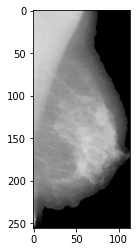

In [2]:
def folder_images(path):
    images = []
    for filename in tqdm(os.listdir(path)):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
    return images
path = '/content/drive/MyDrive/Pec_removed_mini_mias/pec'
original_images = folder_images(path)
plt.imshow(original_images[0],cmap='gray')

'''def original_gray(original):  #function to convert images from bgr to grayscale
    gray_img = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    return gray_img
gray_images = [] #oringinal/base mammogram images 
for img in tqdm(original_images): 
    gray_images.append(original_gray(img))'''    

#print(len(gray_images),gray_images[0].shape)
#plt.imshow(gray_images[0], cmap='gray')

In [3]:
from skimage import io
from skimage import color
from skimage.filters import median
from skimage.morphology import disk
from skimage import exposure
import cv2



def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    image = exposure.equalize_hist(image)
    #image = median(image,disk(5))
    #clahe = cv2.createCLAHE(clipLimit = 5)
    #image = clahe.apply(image) + 0
    return image

In [4]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    #applying canny followed by sobel
    canny_img = canny(image, 3.05)
    #cannny_img = cv2.Canny(image,20,75)
    return sobel(canny_img)
    #return canny_img

In [5]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [6]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 256
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [7]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [8]:
def display_image(filename):
    image = read_image(filename)
    #resized = resize(image)
    
    #print(image1.shape)
    
    #median_image = median(image)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    

    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show() 

    pecless_images.append(image)

    #return image

In [ ]:
#plt.imshow(gray_images[1],cmap='gray')

(231, 117, 3)


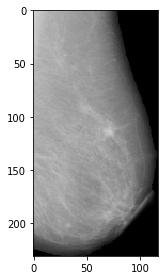

In [14]:
img1 = cv2.imread('/content/drive/MyDrive/cropped_mini_mias/cropped_malignant_resized/11.jpg')
print(img1.shape)
skimage.io.imshow(img1,cmap='gray')


All hough lines
Angle: -0.50, Dist: 31.56
Angle: -23.63, Dist: 12.52
Angle: -4.53, Dist: 49.60
Angle: 6.54, Dist: 51.60
Angle: -38.72, Dist: -11.52
Angle: 26.65, Dist: 104.70
Angle: 38.72, Dist: 130.75
Angle: 1.51, Dist: 70.64
Angle: 81.96, Dist: 202.89
Angle: 8.55, Dist: 91.68
Angle: 67.88, Dist: 203.89

Shorlisted lines
Angle: 26.65, Dist: 104.70
Angle: 38.72, Dist: 130.75
Angle: 67.88, Dist: 203.89


IndexError: ignored

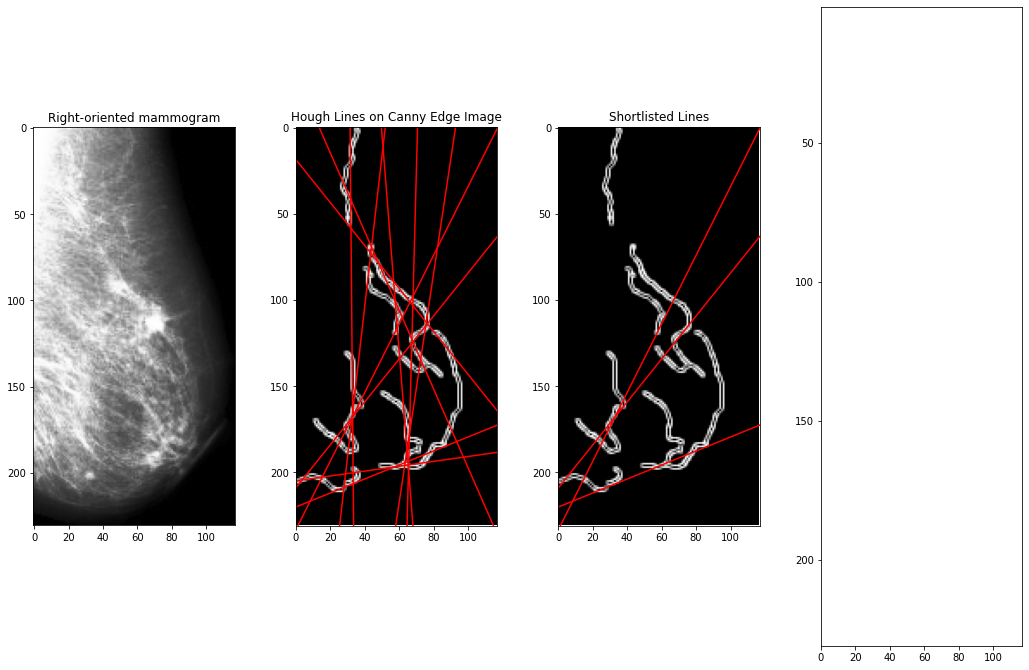

In [15]:
#display_image('/content/drive/MyDrive/cropped_mini_mias/cropped_malignant_resized/1.jpg')
#display_image('/content/drive/MyDrive/Pec_removed_mini_mias/pec/Copy of 13.jpg')
display_image('/content/drive/MyDrive/cropped_mini_mias/cropped_malignant_resized/11.jpg')
#display_image(gray_images[1])

IndexError: ignored

In [ ]:
#img1 = cv2.imread('/content/drive/MyDrive/cropped_mini_mias/cropped_malignant/1.jpg')

In [ ]:
i=0
for img in tqdm(pecless_images):
    
    image = imageio.imwrite('/content/drive/MyDrive/Pec_removed_mini_mias/malignant_pecless/{}.jpg'.format(i),img) 
    i=i+1

  0%|          | 0/51 [00:00<?, ?it/s]


ValueError: ignored